# Online Gradient Computation in JAX

`models` implements a range of neural network models in JAX.

`OnlineCTRNNCell` implements a CT-RNN with custom gradients for RTRL or RFLO. 

The `FADense` module can be configured to use feedback alignment. 

In [40]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import numpy as np
from jax_rtrl.models import FADense, OnlineCTRNNCell
import jax
from jax import numpy as jnp
import jax.random as jrand
import optax

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: attempted relative import with no known parent package

We create a sinusoidal function as a toy dataset. Lets also initialize the model and plot the initial predictions.

In [27]:
key = jrand.PRNGKey(0)
key, key_model, key_data, key_train = jrand.split(key, 4)
x = np.linspace(0, 10*np.pi, 1000)[:, None]
y = np.sin(x) + 2

(1, 1)


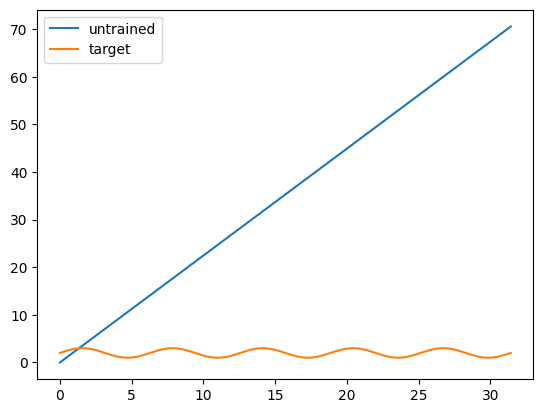

In [32]:
model = FADense(x.shape[-1])
params = model.init(key_model, x)
print(params["params"]["kernel"].shape)
untrained_output = model.apply(params, x).squeeze()

plt.plot(x, untrained_output, label='untrained')
plt.plot(x, y, label='target')
plt.legend()

Next, we define a loss function and compute the loss of the untrained model.

In [29]:
def loss_fn(_params, __x, __y):
    # MSE loss
    y_hat = model.apply(_params, __x)
    return jnp.mean((y_hat - __y)**2)

loss_fn(params, x, y)

Array(1529.4653, dtype=float32)

Now we can train the model and plot the result.

In [34]:
def print_progress(i, loss):
    if i % 1000 == 0:
        print(f'Iteration {i} | Loss: {loss:.3f}')

def train(params, data, key, num_steps=10_000, lr=1e-2, batch_size=128):
    # We use Stochastic Gradient Descent with a constant learning rate
    _x, _y = data
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    def step(carry, n):
        _params, _opt_state, _key = carry
        _key, key_batch = jrand.split(_key)
        batch = jrand.choice(key_batch, np.hstack([_x, _y]), (batch_size,))
        current_loss, grads = jax.value_and_grad(loss_fn)(_params, batch[:,:1], batch[:,1:2])
        updates, _opt_state = optimizer.update(grads, _opt_state, _params)
        _params = optax.apply_updates(_params, updates)
        jax.debug.callback(print_progress, n, current_loss)
        return (_params, _opt_state, _key), current_loss
    (params, *_), losses = jax.lax.scan(step, (params, opt_state, key), np.arange(num_steps, dtype=np.int32))
    print(f'Final loss: {losses[-1]:.3f}')
    return params, losses


Iteration 0 | Loss: 0.952
Iteration 1000 | Loss: 0.473
Iteration 2000 | Loss: 0.435
Iteration 3000 | Loss: 0.481
Iteration 4000 | Loss: 0.529
Iteration 5000 | Loss: 0.502
Iteration 6000 | Loss: 0.472
Iteration 7000 | Loss: 0.486
Iteration 8000 | Loss: 0.485
Iteration 9000 | Loss: 0.499
Final loss: 0.516


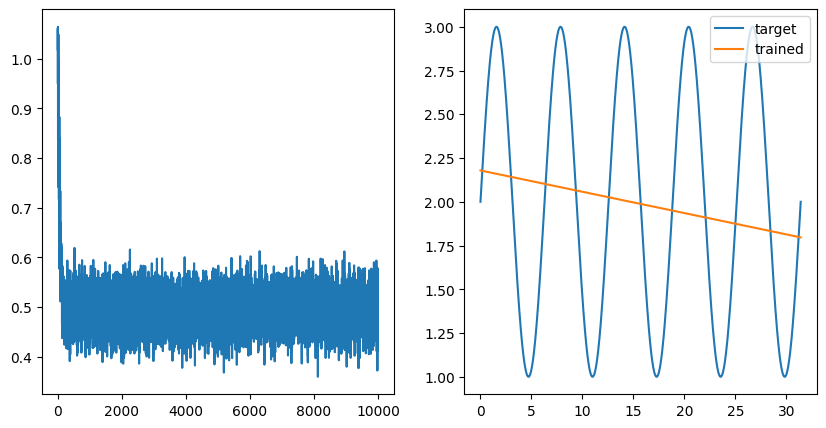

In [35]:
key, key_train = jrand.split(key_data)
params, losses = train(params, (x, y), key)

plt.figure(figsize=(10, 5))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(losses)

# Plot the trained model output
plt.subplot(1, 2, 2)
y_hat = model.apply(params, x)
plt.plot(x, y, label='target')
plt.plot(x, y_hat, label='trained')
plt.legend()

Since the model is Linear it cannot fit the sinusoidal function. Instead we can use a MLP with a single hidden layer.

In [43]:
from jax_rtrl.models import MLP
# from equinox.nn import MLP

# model = MLP(x.shape[-1], y.shape[-1], 
#             width_size=100, depth=2,
#             key=key_model)

model = MLP([128, x.shape[-1]], f_align=True)
params = model.init(key_model, x)


Train one step and see if the loss is decreasing.

Iteration 0 | Loss: 1.848
Final loss: 0.595


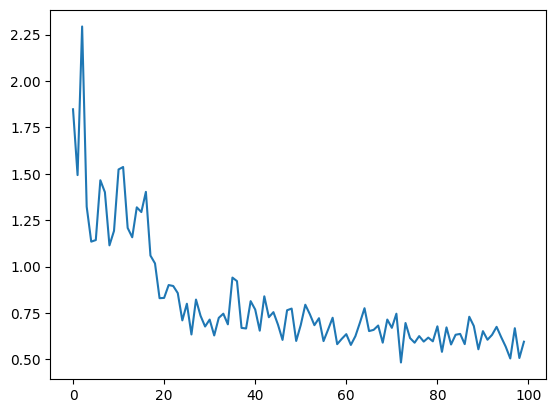

In [44]:
key, key_train = jrand.split(key_data)
params, losses = train(params, (x, y), key_train, num_steps=100)
plt.plot(losses)

Train for some longer ...

Iteration 0 | Loss: 0.787
Iteration 1000 | Loss: 0.377
Iteration 2000 | Loss: 0.322
Iteration 3000 | Loss: 0.352
Iteration 4000 | Loss: 0.457
Iteration 5000 | Loss: 0.496
Iteration 6000 | Loss: 0.381
Iteration 7000 | Loss: 0.423
Iteration 8000 | Loss: 0.358
Iteration 9000 | Loss: 0.302
Iteration 10000 | Loss: 0.629
Iteration 11000 | Loss: 0.412
Iteration 12000 | Loss: 0.464
Iteration 13000 | Loss: 1.136
Iteration 14000 | Loss: 0.413
Iteration 15000 | Loss: 0.620
Iteration 16000 | Loss: 0.767
Iteration 17000 | Loss: 0.401
Iteration 18000 | Loss: 0.334
Iteration 19000 | Loss: 0.403
Final loss: 0.300


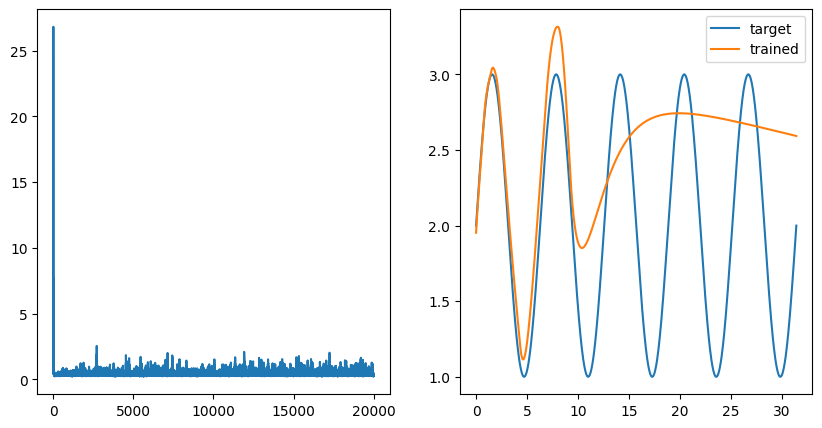

In [47]:
key, key_train = jrand.split(key_data)
params, losses = train(params, (x, y), key_train, num_steps=2e4)

plt.figure(figsize=(10, 5))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(losses)

# Plot the trained model output
plt.subplot(1, 2, 2)
y_hat = model.apply(params, x)
plt.plot(x, y, label='target')
plt.plot(x, y_hat, label='trained')
plt.legend()

## Two spirals dataset

In [48]:
from experiments.supervised.datasets import Spirals
import numpy as np

x, y = Spirals(4, key=key_data)
print(x.shape, y.shape)
def plot_spirals(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for t in range(x.shape[1]):
        ax.scatter(t, x[:, t, 0], x[:, t, 1], c=y)
plot_spirals(x, y)

ModuleNotFoundError: No module named 'experiments'

Let's see how our model performs on the more complex dataset.

In [18]:
model = Linear(np.prod(x.shape[-2:]), y.shape[-1], key=key_model, use_bias=True)
flat_x = x.reshape(x.shape[0], -1)
untrained_output = jax.vmap(model)(flat_x).squeeze()
model, losses = train(model, (flat_x, y), num_steps=1000, key=key_train)
trained_output = jax.vmap(model)(flat_x).squeeze()
plot_spirals(x, trained_output)

TypeError: dot_general requires contracting dimensions to have the same shape, got (32,) and (1,).